In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
np.random.seed(23) 
from scipy import stats
from pathlib import Path
import json


In [2]:
label_graph = nx.DiGraph()
label_graph.add_edge('B','A')

In [3]:
label_graph.add_edge('C','A')
label_graph.add_edge('D','E')
label_graph.add_edge('F','E')
label_graph.add_edge('E','G')
label_graph.add_node('H')

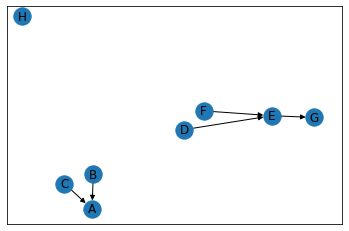

In [4]:
#Visualize Graph
nx.draw_networkx(label_graph, arrows=True)
label_graph_tc = nx.algorithms.transitive_closure(label_graph)


In [6]:

with open(data_dir/'hierarchy_tc.edgelist', 'wb') as f:
    nx.write_edgelist(label_graph_tc, f)

In [8]:
centres = [(60, -40), (50, -10), (65, -40), (-60,60), (-40,40), (-20,20), (-40,40), (-40,-50)]
radii = [40, 10, 5, 10, 45, 15, 60, 20]
labels = sorted(label_graph.nodes())
len(centres)==len(radii)

True

In [86]:
label_names = np.array(labels)
label_names

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype='<U1')

No handles with labels found to put in legend.


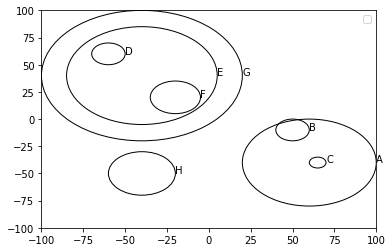

In [9]:
plt.figure()
for i in range(len(labels)):
    circle=plt.Circle(centres[i],radii[i], fill=False)
    plt.gcf().gca().add_artist(circle)
    plt.gca().annotate(labels[i], xy=(centres[i][0]+radii[i], centres[i][1]), fontsize=10)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.legend()
plt.show()

In [1]:
#Generate Gaussian Parameters
mean = centres.copy()
Sigma = []
for i in range(len(labels)):
    #r1 = np.random.uniform(0,radii[i], 1)
    #r2 = np.random.uniform(0, radii[i], 1)
    r1 = radii[i]
    r2 = radii[i]
    corr = np.random.uniform(-0.5,0.5,1)
    Sigma.append(np.array([[r1**2, corr*r1*r2], [corr*r1*r2, r2**2]], dtype=np.float))

NameError: name 'centres' is not defined

In [23]:
print(Sigma[0])

[[1600.         -281.82369645]
 [-281.82369645 1600.        ]]


In [ ]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


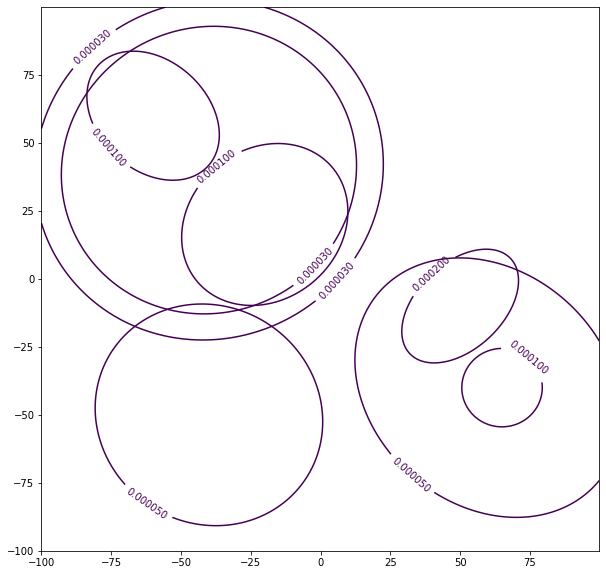

In [72]:
# Generate Data Samples
data = []
plt.figure(figsize=(10,10))
distributions = []
thresholds=[0.00005, 0.0002, 0.0001, 0.0001, 0.00003, 0.0001, 0.00003,0.00005]
for i in tqdm(range(len(labels))):
    #data_sampled = np.random.multivariate_normal(mean[i], Sigma[i], 1000)
    distribution = stats.multivariate_normal(mean=mean[i], cov=Sigma[i])
    distributions.append(distribution)
    #samples = distribution.rvs(size=1000)
    x = np.arange(-100.0, 100.0, 0.1)
    y = np.arange(-100.0, 100.0, 0.1)
    X, Y = np.meshgrid(x, y)
    #X, Y = np.meshgrid(samples[:,0], samples[:,1])
    z = distribution.pdf(np.array([X.reshape(-1), Y.reshape(-1)]).T).reshape(2000,2000)
    cs = plt.contour(X,Y,z, levels=[thresholds[i]])
    plt.clabel(cs, inline=1, fontsize=10, fmt='%1.6f')
    
plt.show()   

In [27]:
thresholds=[0.00005, 0.0002, 0.0001, 0.0001, 0.00003, 0.0001, 0.00003,0.00001]

(1000,)

In [71]:
data_samples = np.random.uniform(-100, 100, size=(10000, 2))

In [84]:
classes = np.array([d.pdf(data_samples) > threshold for threshold, d in zip(thresholds,distributions)]).T

In [94]:
data = [{'x':ds, 'labels': label_names[l].tolist() or ['I']} for ds, l in zip(data_samples.tolist(), classes.tolist())]

100%|██████████| 10000/10000 [01:37<00:00, 102.50it/s]


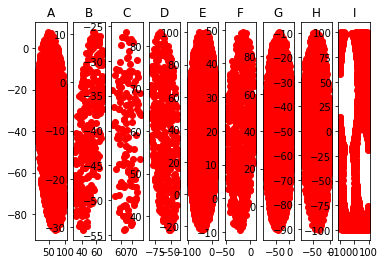

In [107]:
labels_with_i = np.concatenate([label_names, ['I']])
fig, axs = plt.subplots(1,9)
for sample in tqdm(data):
    for l in sample['labels']:
        idx = np.where(labels_with_i==l)[0][0]
        #breakpoint()
        axs[idx].scatter([sample['x'][0]],[sample['x'][1]], c='r')
for i, val in enumerate(labels_with_i):
    axs[i].set_title(val)
plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 260436.51it/s]


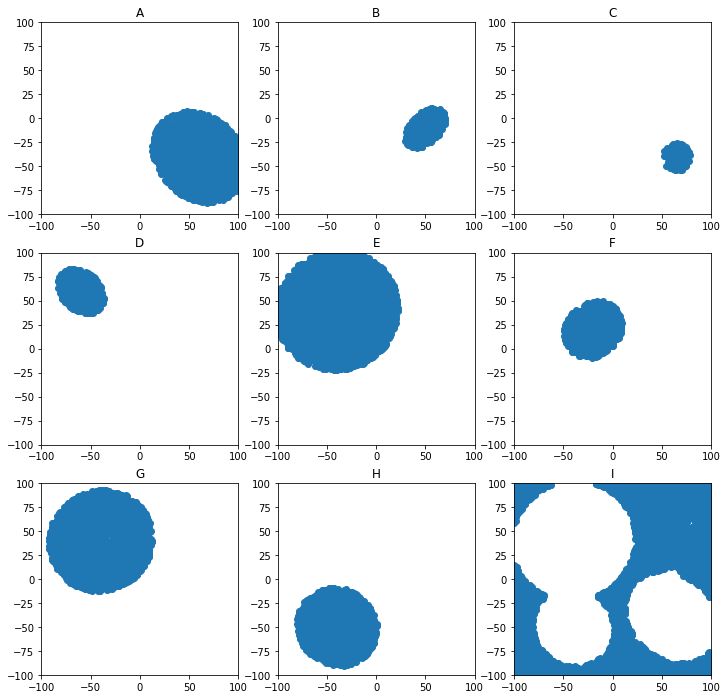

In [114]:
labels_with_i = np.concatenate([label_names, ['I']])
fig, axs = plt.subplots(3,3, figsize=(12,12))
plot_data = [[] for i in range(labels_with_i.shape[0])]
for sample in tqdm(data):
    for l in sample['labels']:
        idx = np.where(labels_with_i==l)[0][0]
        #breakpoint()
        plot_data[idx].append(sample['x'])
axs = axs.reshape(-1) 
for i, val in enumerate(labels_with_i):
    pdata = np.array(plot_data[i])
    axs[i].scatter(pdata[:, 0], pdata[:, 1])
    axs[i].set_title(val)
    axs[i].set_xlim(-100,100)
    axs[i].set_ylim(-100,100)
plt.show()

In [118]:
np.random.shuffle(data)

10000

In [133]:
data_new = []
for d in data:
    d['x'] = list(np.array(d['x'])/100)
    data_new.append(d)

In [134]:
train_len = int(0.5*len(data_new))
dev_len = int(0.5*(len(data_new)-train_len))
train = data_new[:train_len]
dev = data_new[train_len:train_len+dev_len]
test = data_new[train_len+dev_len:]

In [136]:
# with open(data_dir/'train.json', 'w') as outfile:
#     json.dump(train, outfile)
# with open(data_dir/'dev.json', 'w') as outfile:
#     json.dump(dev, outfile)
# with open(data_dir/'test.json', 'w') as outfile:
#     json.dump(test, outfile)

In [131]:
# with open(data_dir/'hierarchy.edgelist', 'wb') as f:
#     nx.write_edgelist(label_graph, f)